# 9.5 Optimising with Numba

*Estimated time for this notebook: 15 minutes*

We saw that we can use Cython to get an approximate 40x speed up when compared to pure Python.
However, this comes with the cost of having to substantially rewrite the Python code to use C syntax.
An alternative is to use [numba](https://numba.pydata.org/), an open source just-in-time compiler that translates a subset of Python and NumPy code into fast machine code.

Let's start by reproducing the pure-Python implementation from earlier.

In [4]:
xmin = -1.5
ymin = -1.0
xmax = 0.5
ymax = 1.0
resolution = 300
xstep = (xmax - xmin) / resolution
ystep = (ymax - ymin) / resolution
xs = [(xmin + xstep * i) for i in range(resolution)]
ys = [(ymin + ystep * i) for i in range(resolution)]

In [5]:
def mandel(constant, max_iterations=50):
    """Computes the values of the series for up to a maximum number of iterations. 
    
    The function stops when the absolute value of the series surpasses 2 or when it reaches the maximum 
    number of iterations.
    
    Returns the number of iterations.
    """
    
    value = 0

    counter = 0
    while counter < max_iterations:
        if abs(value) > 2:
            break

        value = (value * value) + constant

        counter = counter + 1

    return counter


assert mandel(0) == 50
assert mandel(3) == 1
assert mandel(0.5) == 5

In [6]:
%%timeit
# pure python
[[mandel(x + 1j* y) for x in xs] for y in ys]

466 ms ± 16.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Single value numba implementation

Now let's look at a numba implementation for a single value.
We add a Numba decorator to the pure-Python implementation.
Note that ```@njit``` is equivalent to ```@jit(nopython=True)```.

In [111]:
import numpy as np
from matplotlib import pyplot as plt
from numba import njit

# plt.set_cmap("cividis")  # use a CVD-friendly palette

In [12]:
@njit
def mandel_numba(constant, max_iterations=50):
    """Computes the values of the series for up to a maximum number of iterations. 
    
    The function stops when the absolute value of the series surpasses 2 or when it reaches the maximum 
    number of iterations.
    
    Returns the number of iterations.
    """
    
    value = 0

    counter = 0
    while counter < max_iterations:
        if abs(value) > 2:
            break

        value = (value * value) + constant

        counter = counter + 1

    return counter

Note that `numba` will compile the function the first time we invoke it, so the first call will be notably slower than the rest.

In [13]:
import time

start = time.time()
mandel_numba(complex(0, 0))
print(f"Time taken for first call {time.time() - start}s")

Time taken for first call 0.5669119358062744s


In [14]:
assert mandel_numba(0) == 50
assert mandel_numba(3) == 1
assert mandel_numba(0.5) == 5

In [16]:
%%timeit
# Simple numba
[[mandel_numba(x + 1j* y) for x in xs] for y in ys]

50.8 ms ± 3.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


This provides an approximately 10x increase in performance compared to the pure-Python implementation.

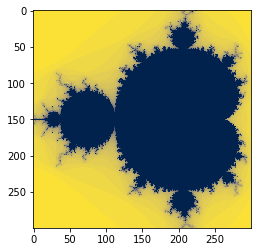

In [8]:
data_numba = [[mandel_numba(complex(x, y)) for x in xs] for y in ys]
plt.imshow(data_numba, interpolation="none")

## Parallelisation with Multiprocessing

Modern CPUs have more than one core. You can find out how many there are on your machine with

In [19]:
from os import cpu_count
cpu_count()

12

In [150]:
%%writefile sleeping.py
from time import sleep

def square(argument):
    sleep(0.5)
    return argument * argument

Overwriting sleeping.py


In [151]:
import sleeping

import importlib
importlib.reload(sleeping)

<module 'sleeping' from '/Users/istenson/code/turing/rse-course/module09_programming_for_speed/sleeping.py'>

In [152]:
assert list(map(sleeping.square, [0, 1, 2, 3])) == [0, 1, 4, 9]

In [153]:
%%timeit -n 2 -r 2
list(map(sleeping.square, [0, 1, 2, 3, 4, 5, 6, 7, 8]))

4.52 s ± 306 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)


In [154]:
from multiprocessing import Pool
with Pool(cpu_count()) as pool:
    results = pool.map(
        sleeping.square,
        [1, 2, 3, 4, 5, 6, 7, 8]
    )
results

[1, 4, 9, 16, 25, 36, 49, 64]

In [155]:
%%timeit pool = Pool(cpu_count())

pool.map(sleeping.square, [1, 2, 3, 4, 5, 6, 7, 8])

557 ms ± 4.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [96]:
pool.close()

## Exercise

- Remove the call to `sleep()`
- Reload the `sleeping` module 
- Run the `list(map(...))` vs `pool.map(...)` comparison again

Which is faster, and by how much? Why?

## Parallelisation with numba

Similarly to `numpy`, `numba` has optimisations related to parallelisation.
Let's see whether we can improve on the performance of `numpy_cython_1`, the best Cython solution we found earlier.
If we are certain that there are no dependencies between different elements in a range, we can parallelize iteration by using the `prange` function.

In [114]:
def mandel_numpy(constants, max_iterations=50):
    """Computes the values of the series for up to a maximum number of iterations. 
    
    The function stops values from exploding once diverged.
    
    Returns the number of iterations.
    """
    
    value = np.zeros(constants.shape)
    # An array which keeps track of the first step at which each position diverged
    diverged_at_count = np.ones(constants.shape)*max_iterations
    counter = 0
    while counter < max_iterations:
        value = value*value + constants
        diverging = abs(value) > 2
        
        # Any positions which are:
        # - diverging
        # - haven't diverged before
        # are diverging for the first time
        first_diverged_this_time = np.logical_and(
            diverging,
            diverged_at_count == max_iterations
        )
        
        # Update diverged_at_count for all positions which first diverged at this step
        diverged_at_count[first_diverged_this_time] = counter
        # Reset any divergent values to exactly 2
        value[diverging] = 2
        counter = counter + 1

    return diverged_at_count

assert mandel_numpy(np.asarray([0])) == np.asarray([50])
assert mandel_numpy(np.asarray([4])) == np.asarray([0])

In [125]:
cs_listcomp = [[(x + y*1j) for x in xs] for y in ys]
cs = np.asarray(cs_listcomp)

(-1.4866666666666666-0.9933333333333333j)

In [120]:
%%timeit
mandel_numpy(cs)

37.5 ms ± 3.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [156]:
from numba import prange
help(prange)

Help on class prange in module numba.misc.special:

class prange(builtins.object)
 |  prange(*args)
 |  
 |  Provides a 1D parallel iterator that generates a sequence of integers.
 |  In non-parallel contexts, prange is identical to range.
 |  
 |  Static methods defined here:
 |  
 |  __new__(cls, *args)
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



In [160]:
@njit(parallel=True)
def mandel_numba_parallel(constants, max_iterations=50):
    """Computes the values of the series for up to a maximum number of iterations.
    
    Returns the number of iterations.
    """
    xlim = constants.shape[1]
    ylim = constants.shape[0]
    
    diverged_at_count = np.zeros((ylim, xlim))
    
    for y in prange(ylim):
        for x in prange(xlim):
            
            value = 0
            counter = 0
            
            while counter < max_iterations:
                if abs(value) > 2:
                    break

                value = (value * value) + constants[y, x]

                counter = counter + 1
            
            diverged_at_count[y, x] = counter

    return diverged_at_count


In [161]:
assert mandel_numba_parallel(np.asarray([[0]])) == np.asarray([[50]])
assert mandel_numba_parallel(np.asarray([[4]])) == np.asarray([[1]])

In [162]:
%%timeit
mandel_numba_parallel(cs)

2.15 ms ± 120 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [164]:
zs = mandel_numba_parallel(cs)

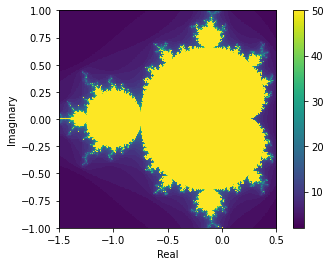

In [165]:
plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.imshow(
    zs,
    interpolation="none",
    extent=[xmin, xmax, ymin, ymax],
    origin="lower"
)
plt.colorbar()

In [ ]:
## Self study (parallelising mandel)

In [16]:
cs = [[(x + y*1j) for x in xs] for y in ys]
print(len(cs))
print(type(cs[0]))

300
<class 'list'>


In [18]:
map(len, cs[0:10])

In [20]:
list(map(len, cs[0:10]))

[300, 300, 300, 300, 300, 300, 300, 300, 300, 300]

In [42]:
%%writefile mandelrow.py
def mandel(position, limit=50):
    value = position
    while abs(value) < 2:
        limit -= 1
        value = value**2 + position
        if limit < 0:
            return 0
    return limit

def mandel_row(row):
    """Apply mandel to a row."""
    return [mandel(cell) for cell in row]

assert mandel_row([1, 2, 3]) == [49, 50, 50]

Overwriting mandelrow.py


In [43]:
from mandelrow import mandel_row

In [44]:
%%timeit
zs = list(map(mandel_row, cs))

644 ms ± 9.71 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


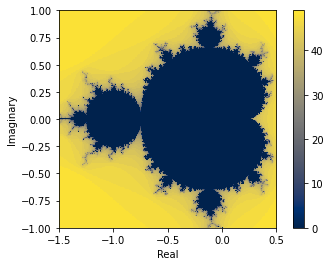

In [45]:
plt.set_cmap("cividis")  # use a color vision deficiency-friendly palette
plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.imshow(
    zs,
    interpolation="none",
    extent=[xmin, xmax, ymin, ymax],
    origin="lower"
)
plt.colorbar()

In [52]:
with Pool(cpu_count()) as pool:
    p_zs = pool.map(mandel_row, cs)

In [53]:
%%timeit pool = Pool(cpu_count())

p_zs = pool.map(mandel_row, cs)

156 ms ± 5.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [56]:
pool.close()

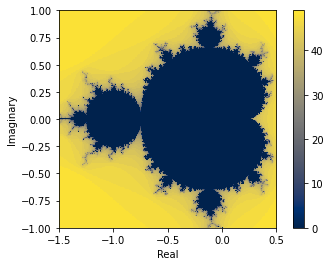

In [55]:
plt.set_cmap("cividis")  # use a color vision deficiency-friendly palette
plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.imshow(
    p_zs,
    interpolation="none",
    extent=[xmin, xmax, ymin, ymax],
    origin="lower"
)
plt.colorbar()